In [12]:
import pandas as pd
import numpy as np
import os, sys
import random
import pydicom
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
seed = 42

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras

keras.mixed_precision.set_global_policy("mixed_float16")

from keras import layers, Model
from keras import ops, layers, models, losses, optimizers, metrics
import keras_hub
import keras_cv
import keras_nlp

import cv2
from skimage.io import imread
keras.utils.set_random_seed(seed)
import tensorflow_io as tfio
from kaggle_datasets import KaggleDatasets
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

print(f"Tensorflow version : {tf.__version__}")
try:
    print(f"Keras version : {keras.__version__}")
except:
    pass

from keras import Input, Model, ops
from keras.models import load_model

from keras.layers import Conv2D, DepthwiseConv2D, Dense, Activation, BatchNormalization, LayerNormalization, MultiHeadAttention, Embedding, Subtract, Add, Multiply, GlobalAveragePooling2D, GlobalAveragePooling1D, LayerNormalization
from keras.utils import load_img, img_to_array
from keras.applications import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
import wandb
def wandb_config():
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    try:
        secret_value_0 = user_secrets.get_secret("__gcloud_sdk_auth__")
        secret_value_1 = user_secrets.get_secret("huggingface_key")
        secret_value_2 = user_secrets.get_secret("wandb_key")
        !wandb login $secret_value_2
    except:
        secret_value_0 = user_secrets.get_secret("huggingface_key")
        secret_value_1 = user_secrets.get_secret("wandb_key")
        !wandb login $secret_value_1
    
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        tpu = False
        strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return tpu, strategy

tpu, strategy = auto_select_accelerator()

import PIL
from PIL import Image as PILImage
import matplotlib as mpl
import matplotlib.pyplot as plt

import pprint
from pprint import pprint as pp

res = 384
batch_size = 16
viz = False

Tensorflow version : 2.18.0
Keras version : 3.8.0
Running on 1 replicas


In [13]:
def _parse_tfrecord(res = res):
    def parse_tfrecord(tfrecord):
        features = {'image': tf.io.FixedLenFeature([], tf.string),
                    'label': tf.io.FixedLenFeature([], tf.int64),
                    }
        x = tf.io.parse_single_example(tfrecord, features)
        image_train = tf.image.decode_jpeg(x['image'], channels=1)
        image_train = _transform_images(res = res)(image_train)
        label = tf.cast(x["label"], tf.int32)
        return (image_train, label)
    
    return parse_tfrecord


def _transform_images(res = res):
    def transform_images(x_train):
        x_train = tf.image.resize_with_pad(x_train, res, res, antialias = True)
        x_train = tf.cast(x_train, tf.uint8)
        return x_train
    return transform_images

def load_tfrecord_dataset(tfrecord_name, res = res, batch_size = batch_size, shuffle=True, buffer_size=10240):
    """load dataset from tfrecord"""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name, compression_type = "GZIP")
    raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
    dataset = raw_dataset.map(
        _parse_tfrecord(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size, drop_remainder = True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_radimagenet_ds = load_tfrecord_dataset("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RagImageNet_Train_GZIP.tfrecord")
val_ds = load_tfrecord_dataset("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RagImageNet_Test_GZIP.tfrecord")

'+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+='
'Total Training case : 1191117'
'                                     LABELS'
     index                      name
0        0                  US-aorta
1        1                US-bladder
2        2                    US-cbd
3        3                US-fibroid
4        4                     US-gb
..     ...                       ...
160    160  spine-foraminal pathlogy
161    161              spine-normal
162    162         spine-osseous abn
163    163           spine-scoliosis
164    164            thyroid-nodule

[165 rows x 2 columns]
'+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+='


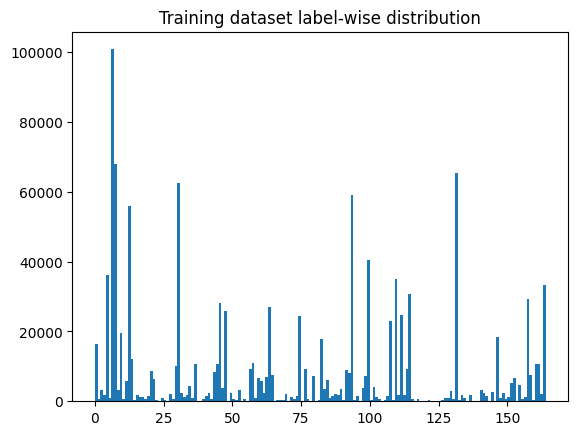

In [14]:
df_train = pd.read_csv("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RadImgNet_train.csv")
plt.hist(df_train["label"], bins = range(165))
plt.title("Training dataset label-wise distribution")

pp("+="*50)
pp(f"Total Training case : {len(df_train)}")
pp("                                     LABELS")
df_label = pd.read_csv("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RadImgNet_label_encoding.csv")
pp(df_label)
pp("+="*50)

In [ ]:
if viz:
    for img, lab in train_radimagenet_ds.take(1):
        imgs = img
        labs = lab
    fig, axes = plt.subplots(4,4, figsize = (15,15))
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        ax.imshow(imgs[idx], cmap = "bone")
        lab_ = int(labs[idx])
        name = df_label.loc[df_label.index == lab_, 'name'].values[0]
        ax.set_title(f"{lab_} : {name}")
    plt.show()
    print(keras.ops.max(imgs))

In [15]:
class ClassToken(keras.layers.Layer):
    def build(self, input_shape):
        self.cls = self.add_weight(
            name="cls",
            shape=(1, 1, input_shape[-1]),
            initializer="zeros",
            trainable=True
        )
    
    def call(self, inputs):
        # static shape: inputs.shape[0] → None
        # dynamic shape: tf.shape(inputs)[0] → 실제 배치 크기(tensor)
        batch_size = tf.shape(inputs)[0]
        
        # cls 텐서를 [batch_size, 1, embed_dims]로 브로드캐스트
        cls_broadcasted = tf.broadcast_to(
            self.cls, 
            [batch_size, 1, tf.shape(inputs)[-1]]
        )
        # CLS 토큰과 패치를 concat
        return tf.concat([cls_broadcasted, inputs], axis=1)


def get_vit(att_heads = 8, att_depth = 6, embed_dims = 512, mode = "naive"):
    inputs = Input((res,res,1), name = "RadImgNetInput")
    if mode == "vitdet":
        backbone = keras_hub.models.ViTDetBackbone( 
                                                    hidden_size = 768,
                                                    num_layers = 8,
                                                    intermediate_dim = 768,
                                                    num_heads = 12,
                                                    global_attention_layer_indices = [2,5,7],
                                                    image_shape=(res, res, 1),
                                                    patch_size=16,
                                                    num_output_channels=embed_dims,
                                                    use_bias=True,
                                                    use_abs_pos=True,
                                                    use_rel_pos=True,
                                                    window_size=14,
                                                    layer_norm_epsilon=1e-06,
                                                    include_rescaling = True
                                                )
        
    elif mode == "effnet":
        backbone = keras.applications.EfficientNetV2S(input_shape = [res,res,1], include_top = False, weights = None)
    else:
        backbone = Conv2D(filters = embed_dims, padding = 'SAME', kernel_size = 16, strides = 16, name = "PatchingConv", activation = "gelu")
    
    if (mode == "effnet") or (mode == "vitdet"):
        patches = backbone(inputs)
    else:
        patches = backbone(inputs/255)
        patches = keras_hub.layers.RotaryEmbedding(name = "RoPE")(patches)
    _, w, h, d_ = keras.ops.shape(patches)
    cls_layer = ClassToken()
    
    patches = ops.reshape(patches, [-1, w*h, embed_dims]) ; seq_len = w*h
    patches = cls_layer(patches)
    att_weights = {}
    for idx in range(att_depth):
        x0 = LayerNormalization(name = f'preLN{idx}')(patches)
        x1, att_score = MultiHeadAttention(att_heads, embed_dims//att_heads, name = f"MHA{idx}")(query = x0, key = x0, value = x0,
                                                                                     return_attention_scores = True)
        att_weights[idx] = att_score
        x2 = x1 + patches
        x3 = LayerNormalization(name = f'postLN{idx}')(x2)
        x4 = Dense(units = embed_dims, name = f"MLP{idx}", activation = "gelu")(x3)
        patches = x2 + x4
        patches = keras.layers.Identity(name = f"EncodedPatches_{idx}")(patches)
    feature_vector = patches[:, 0, :]
    model = Model(inputs, [feature_vector, att_weights],
                 name = f"{mode}ViT_depth{att_depth}_heads{att_heads}_dims{embed_dims}")
    return model

> ViTOL 등을 위한 pADL 및 vision transformer

In [16]:
class pADL(layers.Layer):
    def __init__(self, embedding_drop_rate=0.5, drop_threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.embedding_drop_rate = embedding_drop_rate
        self.drop_threshold = drop_threshold

    
    @tf.function
    def call(self, attention_output, training=None):
        if not training:
            return attention_output

        # 어텐션 출력에서 CLS 토큰에 해당하는 부분만 사용
        cls_attention = attention_output[:, 0, :] # [batch_size, projection_dim]
        
        # 패치 중요도 맵 (Patch Importance Map)
        importance_map = ops.sigmoid(cls_attention)
        #importance
        # 패치 드롭 마스크 (Patch Drop Mask)
        # 활성화가 가장 큰 패치를 드롭
        max_indices = ops.argmax(cls_attention, axis=-1)
        drop_mask = tf.one_hot(max_indices, depth=ops.shape(cls_attention)[-1])
        drop_mask = 1.0 - drop_mask
        
        # 드롭아웃 적용 여부 랜덤 선택
        random_value = tf.random.uniform(shape=())
        if random_value > self.embedding_drop_rate:
            # 드롭 마스크 적용
            selected_map = ops.cast(drop_mask, "float16")
        else:
            # 중요도 맵 적용
            selected_map = importance_map
            
        # 원래 어텐션 출력에 마스크 적용
        # 브로드캐스팅을 위해 차원 확장
        selected_map = ops.expand_dims(selected_map, axis=1) # [batch_size, 1, projection_dim]
        selected_map = keras.ops.cast(selected_map, "float16")
        return attention_output * selected_map

class FreeViTEncoder(Model):
    """
    상태 제어가 가능한 ViT 인코더 클래스.
    pADL 레이어를 포함하며, use_padl 플래그로 활성화 여부를 제어합니다.
    """
    def __init__(self, att_heads=12, att_depth=8, embed_dims=512, name="FreeViTEncoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.att_heads = att_heads
        self.att_depth = att_depth
        self.embed_dims = embed_dims
        
        # 외부에서 제어할 플래그
        self.use_padl = False 

        # 1. Patch Embedding Layers (기존 로직과 동일)
        self.patch_conv = layers.Conv2D(filters=embed_dims // 4, padding='SAME', 
                                        kernel_size=16, strides=16, name="PatchingConv", activation="gelu")
        self.mini_res_blocks = []
        for r in range(4):
            self.mini_res_blocks.append([
                layers.LayerNormalization(name=f"MiniResLN_pre_{r}"),
                layers.Conv2D(filters=embed_dims // 4, padding='SAME', kernel_size=3, name=f"MiniResConv_{r}", activation='gelu'),
                layers.LayerNormalization(name=f"MiniResLN_post_{r}"),
                layers.Dense(units=embed_dims // 4, activation="gelu", name=f"MiniResMLP_{r}")
            ])
        self.final_embedding = layers.Dense(units=embed_dims, activation="gelu", name="FinalEmbedding")
        self.reshape_layer = layers.Reshape((-1, embed_dims), name='Reshape')
        self.cls_layer = ClassToken(name = "AppendLearnableCLSToken")

        # 2. Transformer Blocks with pADL
        self.transformer_blocks = []
        for idx in range(att_depth):
            self.transformer_blocks.append({
                "pre_ln": layers.LayerNormalization(name=f'preLN{idx}'),
                "mha": layers.MultiHeadAttention(att_heads, embed_dims // att_heads, name=f"MHA{idx}"),
                "padl": pADL(name=f"pADL_{idx}"), # pADL 레이어를 미리 생성
                "post_ln": layers.LayerNormalization(name=f'postLN{idx}'),
                "mlp": layers.Dense(units=embed_dims, name=f"MLP{idx}", activation="gelu")
            })
            
        # 3. Output Identity Layers for clear naming
        self.cls_token_out = layers.Identity(name="CLS_Token")
        self.patch_tokens_out = layers.Identity(name="Patch_Tokens")

    def call(self, inputs, training=True, apply_padl = True):
        # Patch Embedding
        x = self.patch_conv(inputs / 255)
        for r_block in self.mini_res_blocks:
            x_res = x
            x_norm = r_block[0](x)
            x = r_block[1](x_norm)
            x = x + x_res
            x_res = x
            x_norm = r_block[2](x)
            x = r_block[3](x_norm)
            x = x + x_res
        x = self.final_embedding(x)
        x = keras.layers.Reshape((-1, self.embed_dims))(x)
        x = self.cls_layer(x)
        # Transformer Blocks
        for block in self.transformer_blocks:
            x_res = x
            x_norm = block["pre_ln"](x)
            attn_out = block["mha"](query=x_norm, key=x_norm, value=x_norm, training=training)
            
            # 여기서 pADL 활성화 여부를 제어
            if self.use_padl :
                attn_out = block["padl"](attn_out, training=training)

            x = attn_out + x_res
            x_res = x
            x_norm = block["post_ln"](x)
            x = block["mlp"](x_norm)
            x = x + x_res
        
        cls_token = self.cls_token_out(x[:, 0, :])
        patch_tokens = self.patch_tokens_out(x[:, 1:, :])
        return cls_token, patch_tokens

# 실험계획
- 비교군 : original github의 result 및 ViT실험
- Supervised contrastive learning
- N회 SSL 후 1회 classifier까지 learning을 반복 --> called 1 "set"

In [17]:
# dino trainer
resize_fn = keras.layers.Resizing(res,res)
def get_two_views(images):
    global_view_1 = keras.layers.RandomCrop(256,256)(images)
    global_veiw_2 = keras.layers.RandomCrop(180,180)(images)
    global_view_1, global_view_2 = resize_fn(global_view_1), resize_fn(global_view_2)
    return (global_view_1, global_view_2)



class MiniDINO(Model):
    """
    Miniature DINO model using a pre-existing Vision Transformer backbone.
    This implementation follows the principles from the DINO and DINOv2 papers.
    """
    def __init__(
        self,
        student_backbone,
        teacher_backbone,
        projection_dim=1024,
        latent_dim=512,
        teacher_momentum=0.996,
        center_momentum=0.9,
        student_temp=0.1,
        teacher_temp=0.04,
        **kwargs
    ):
        """
        Args:
            student_backbone (Model): The student ViT model.
            teacher_backbone (Model): The teacher ViT model (should have the same architecture).
            projection_dim (int): The dimension of the projection head's hidden layer.
            latent_dim (int): The output dimension of the projection head (and input from backbone).
            teacher_momentum (float): The momentum for the teacher network update.
            center_momentum (float): The momentum for the center update.
            student_temp (float): The temperature for the student's softmax.
            teacher_temp (float): The temperature for the teacher's softmax (sharpening).
        """
        super().__init__(**kwargs)
        self.student_backbone = student_backbone
        self.teacher_backbone = teacher_backbone
        self.teacher_momentum = teacher_momentum
        self.center_momentum = center_momentum
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.latent_dim = latent_dim
        self.resize_fn = keras.layers.Resizing(res,res)
        self.rc1 = keras.layers.RandomCrop(256,256)
        self.rc2 = keras.layers.RandomCrop(180,180)
        # DINO Projection Head
        self.student_projector = self._build_projector(latent_dim, projection_dim)
        self.teacher_projector = self._build_projector(latent_dim, projection_dim)

        # Initialize teacher weights with student weights
        self.teacher_backbone.set_weights(self.student_backbone.get_weights())
        self.teacher_projector.set_weights(self.student_projector.get_weights())

        # Center vector for teacher output centering [14]
        self.center = self.add_weight(
            shape=(1, latent_dim), initializer="zeros", trainable=False, name="center"
        )
        
        # Trackers for metrics
        self.loss_tracker = keras.metrics.Mean(name="dino_loss")
    def _get_two_views(self, images):
        global_view_1 = self.rc1(images)
        global_view_2 = self.rc2(images)
        global_view_1, global_view_2 = self.resize_fn(global_view_1), self.resize_fn(global_view_2)
        return (global_view_1, global_view_2)
    def _build_projector(self, latent_dim, projection_dim):
        """Builds the MLP projection head as described in DINO."""
        # A simpler 2-layer MLP for this miniature version.
        # Original DINO uses a 3-layer MLP.
        return keras.Sequential(
            [
                layers.Input(shape=(latent_dim,)),
                layers.Dense(projection_dim, activation="gelu"),
                layers.Dense(latent_dim),
            ],
            name="projector",
        )

    def _update_teacher(self):
        """Update teacher network weights using EMA of student weights."""
        for student_w, teacher_w in zip(self.student_backbone.weights, self.teacher_backbone.weights):
            teacher_w.assign(self.teacher_momentum * teacher_w + (1 - self.teacher_momentum) * student_w)
        for student_w, teacher_w in zip(self.student_projector.weights, self.teacher_projector.weights):
            teacher_w.assign(self.teacher_momentum * teacher_w + (1 - self.teacher_momentum) * student_w)

    @tf.function
    def _update_center(self, teacher_output):
        """Update the center vector using EMA of teacher outputs."""
        batch_center = tf.reduce_mean(teacher_output, axis=0, keepdims=True)
        self.center.assign(self.center_momentum * self.center + (1 - self.center_momentum) * batch_center)

    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer

    def train_step(self, data):
        # The data should be a tuple of two lists of augmented views: (global_crops, local_crops)
        # For simplicity, this example assumes two global crops.
        images, label = data
        view1, view2 = self._get_two_views(images)

        with tf.GradientTape() as tape:
            # === Teacher Forward Pass (no gradients) ===
            teacher_repr1 = self.teacher_backbone(view1, training=False)
            teacher_repr2 = self.teacher_backbone(view2, training=False)
            
            teacher_proj1 = self.teacher_projector(teacher_repr1, training=False)
            teacher_proj2 = self.teacher_projector(teacher_repr2, training=False)

            # Center and sharpen teacher outputs [14]
            teacher_out1 = tf.nn.softmax((teacher_proj1 - self.center) / self.teacher_temp, axis=-1)
            teacher_out2 = tf.nn.softmax((teacher_proj2 - self.center) / self.teacher_temp, axis=-1)

            # === Student Forward Pass ===
            student_repr1 = self.student_backbone(view1, training=True)
            student_repr2 = self.student_backbone(view2, training=True)

            student_proj1 = self.student_projector(student_repr1, training=True)
            student_proj2 = self.student_projector(student_repr2, training=True)

            student_out1 = tf.nn.log_softmax(student_proj1 / self.student_temp, axis=-1)
            student_out2 = tf.nn.log_softmax(student_proj2 / self.student_temp, axis=-1)

            # === Compute DINO Loss (Cross-Entropy) ===
            # The student predicts the teacher's output for a different view.
            loss1 = -tf.reduce_mean(tf.reduce_sum(teacher_out2 * student_out1, axis=-1))
            loss2 = -tf.reduce_mean(tf.reduce_sum(teacher_out1 * student_out2, axis=-1))
            total_loss = (loss1 + loss2) / 2

        # === Gradient Descent ===
        trainable_vars = self.student_backbone.trainable_variables + self.student_projector.trainable_variables
        grads = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # === EMA Updates ===
        self._update_teacher()
        self._update_center(tf.concat([teacher_proj1, teacher_proj2], axis=0))

        self.loss_tracker.update_state(total_loss)
        return {"loss": self.loss_tracker.result()}
    
    def call(self, inputs):
        # For inference, only the student backbone is used.
        return self.student_backbone(inputs)

student_vit = get_vit()
teacher_vit = get_vit()

dino_model = MiniDINO(
    student_backbone=student_vit,
    teacher_backbone=teacher_vit,
    #latent_dim=EMBED_DIM
)

dino_model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4))
#dino_model.fit(train_radimagenet_ds, epochs = 1, steps_per_epoch = 500)

# DINO with supervision

In [23]:
class MiniSupDINO(Model):
    def __init__(
        self,
        student_backbone,
        teacher_backbone,
        mode = 'supervised', #supervised or dino
        projection_dim=1024,
        latent_dim=512,
        teacher_momentum=0.996,
        center_momentum=0.9,
        student_temp=0.1,
        teacher_temp=0.04,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.mode = mode
        self.student_backbone = student_backbone
        self.teacher_backbone = teacher_backbone
        self.teacher_momentum = teacher_momentum
        self.center_momentum = center_momentum
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.latent_dim = latent_dim
        self.rc = keras.layers.RandomCrop(int(0.75*res),int(0.75*res))
        # DINO Projection Head
        self.student_projector = self._build_projector(latent_dim, projection_dim)
        self.teacher_projector = self._build_projector(latent_dim, projection_dim)
        # Supervision (Classifier) Head
        self.student_classifier = keras.layers.Dense(units = 165, name = "Student_RadImgNetClassifier", dtype="float32")
        self.teacher_classifier = keras.layers.Dense(units = 165, name = "Teacher_RadImgNetClassifier", dtype="float32")
        # Initialize teacher weights with student weights
        self.teacher_backbone.set_weights(self.student_backbone.get_weights())
        self.teacher_projector.set_weights(self.student_projector.get_weights())
        self.teacher_classifier.set_weights(self.student_classifier.get_weights())

        # Center vector for teacher output centering [14]
        self.center = self.add_weight(
            shape=(1, latent_dim), initializer="zeros", trainable=False, name="center"
        )
        self.center_cls = self.add_weight(
            shape=(1, 165), initializer="zeros", trainable=False, name="center_class_proba"
        )
        
        # Trackers for metrics
        self.loss_tracker = keras.metrics.Mean(name="Total_loss")
        self.dino_loss_tracker = keras.metrics.Mean(name="DINO_loss")
        self.student_cls_loss_tracker = keras.metrics.Mean(name="Student_class_loss")
        self.cls_distil_loss_tracker = keras.metrics.Mean(name="Class_distil_loss")

        self.student_acc_tracker = keras.metrics.Mean(name = "Student_class_Accuracy")
        self.teacher_acc_tracker = keras.metrics.Mean(name = "Teacher_class_Accuracy")
        self.compute_acc = keras.metrics.SparseCategoricalAccuracy()

    def _get_two_views(self, images):
        global_view_1 = images
        global_view_2 = self.rc(images)
        #global_view_2 = keras.layers.Resizing(res,res)(global_view_2)
        return (global_view_1, global_view_2)
    def _build_projector(self, latent_dim, projection_dim):
        """Builds the MLP projection head as described in DINO."""
        # A simpler 2-layer MLP for this miniature version.
        # Original DINO uses a 3-layer MLP.
        return keras.Sequential(
            [
                layers.Input(shape=(latent_dim,)),
                layers.Dense(projection_dim, activation="gelu"),
                layers.Dense(latent_dim, dtype="float32"),
            ],
            name="projector",
        )

    def _update_teacher(self):
        """Update teacher network weights using EMA of student weights."""
        for student_w, teacher_w in zip(self.student_backbone.weights, self.teacher_backbone.weights):
            teacher_w.assign(self.teacher_momentum * teacher_w + (1 - self.teacher_momentum) * student_w)
        for student_w, teacher_w in zip(self.student_projector.weights, self.teacher_projector.weights):
            teacher_w.assign(self.teacher_momentum * teacher_w + (1 - self.teacher_momentum) * student_w)
        if (self.mode == "sup") or (self.mode == "supervised"):
            for student_w, teacher_w in zip(self.student_classifier.weights, self.teacher_classifier.weights):
                teacher_w.assign(self.teacher_momentum * teacher_w + (1 - self.teacher_momentum) * student_w)
    @tf.function
    def _update_center(self, teacher_output, teacher_proba_output = None):
        """Update the center vector using EMA of teacher outputs."""
        batch_center = tf.reduce_mean(teacher_output, axis=0, keepdims=True)
        self.center.assign(self.center_momentum * self.center + (1 - self.center_momentum) * batch_center)
        if (self.mode == "sup") or (self.mode == "supervised"):
            batch_center_proba = tf.reduce_mean(teacher_proba_output, axis = 0, keepdims = True)
            self.center_cls.assign(self.center_momentum * self.center_cls + (1 - self.center_momentum)*batch_center_proba)

    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer

    def train_step(self, data):
        # The data should be a tuple of two lists of augmented views: (global_crops, local_crops)
        # For simplicity, this example assumes two global crops.
        images, label = data
        view1, view2 = self._get_two_views(images)

        with tf.GradientTape() as tape:
            # === Teacher Forward Pass (no gradients) ===
            teacher_repr1 = self.teacher_backbone(view1, training=False)[0]
            teacher_repr2 = self.teacher_backbone(view2, training=False)[0]
            
            teacher_proj1 = self.teacher_projector(teacher_repr1, training=False)
            teacher_proj2 = self.teacher_projector(teacher_repr2, training=False)

            # Center and sharpen teacher outputs [14]
            teacher_out1 = tf.nn.softmax((teacher_proj1 - self.center) / self.teacher_temp, axis=-1)
            teacher_out2 = tf.nn.softmax((teacher_proj2 - self.center) / self.teacher_temp, axis=-1)

            # === Student Forward Pass ===
            student_repr1 = self.student_backbone(view1, training=True)[0]
            student_repr2 = self.student_backbone(view2, training=True)[0]

            student_proj1 = self.student_projector(student_repr1, training=True)
            student_proj2 = self.student_projector(student_repr2, training=True)

            student_out1 = tf.nn.log_softmax(student_proj1 / self.student_temp, axis=-1)
            student_out2 = tf.nn.log_softmax(student_proj2 / self.student_temp, axis=-1)

            # === Compute DINO Loss (Cross-Entropy) ===
            # The student predicts the teacher's output for a different view.
            loss1 = -tf.reduce_mean(tf.reduce_sum(teacher_out2 * student_out1, axis=-1))
            loss2 = -tf.reduce_mean(tf.reduce_sum(teacher_out1 * student_out2, axis=-1))
            loss1, loss2 = keras.ops.clip(loss1, -100.0,100.0), keras.ops.clip(loss2, -100.0,100.0)
            dino_loss = (loss1 + loss2) / 2
            if (self.mode == "sup") or (self.mode == "supervised"):
                # calculate student class proba
                cls_s_1 = self.student_classifier(student_repr1, training = True)
                cls_s_2 = self.student_classifier(student_repr2, training = True)
                cls_t_1 = self.teacher_classifier(teacher_repr1, training = False)
                cls_t_2 = self.teacher_classifier(teacher_repr2, training = False)
                # supervised loss
                student_cls_loss = 0.5*(keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = None)(y_true = label, y_pred = cls_s_1) + keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = None)(y_true = label, y_pred = cls_s_2))
                student_accuracy = 0.5*(self.compute_acc(y_true = label, y_pred = cls_s_1) + self.compute_acc(y_true = label, y_pred = cls_s_2))
                student_cls_loss = keras.ops.mean(student_cls_loss)
                
                teacher_accuracy = 0.5*(self.compute_acc(y_true = label, y_pred = cls_t_1) + self.compute_acc(y_true = label, y_pred = cls_t_2))
                
                # classifier dino loss
                cls_t_1 = tf.nn.softmax((cls_t_1 - self.center_cls) / self.teacher_temp, axis=-1)
                cls_t_2 = tf.nn.softmax((cls_t_2 - self.center_cls) / self.teacher_temp, axis=-1)

                cls_s_1 = tf.nn.log_softmax(cls_s_1 / self.student_temp, axis=-1)
                cls_s_2 = tf.nn.log_softmax(cls_s_2 / self.student_temp, axis=-1)
                cls_distil_loss_1 = -tf.reduce_mean(tf.reduce_sum(cls_t_2 * cls_s_1, axis=-1))
                cls_distil_loss_2 = -tf.reduce_mean(tf.reduce_sum(cls_t_1 * cls_s_2, axis=-1))
                cls_distil_loss = (cls_distil_loss_1 + cls_distil_loss_2) / 2

                total_loss = dino_loss + student_cls_loss + cls_distil_loss
            else:
                total_loss = dino_loss
                student_cls_loss = 0.0
                cls_distil_loss = 0.0
                student_accuracy = 0.0
                teacher_accuracy = 0.0
                cls_t_1, cls_t_2 = [0.0], [0.0]
            
        # === Gradient Descent ===
        trainable_vars = self.student_backbone.trainable_variables + self.student_projector.trainable_variables
        if (self.mode == "sup") or (self.mode == "supervised"):
            trainable_vars += self.student_classifier.trainable_variables
        grads = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # === EMA Updates ===
        self._update_teacher()
        self._update_center(tf.concat([teacher_proj1, teacher_proj2], axis=0),
                           tf.concat([cls_t_1, cls_t_2], axis = 0)
                           )

        self.loss_tracker.update_state(total_loss)
        self.dino_loss_tracker.update_state(dino_loss)
        self.student_cls_loss_tracker.update_state(student_cls_loss)
        self.cls_distil_loss_tracker.update_state(cls_distil_loss)

        self.student_acc_tracker.update_state(student_accuracy)
        self.teacher_acc_tracker.update_state(teacher_accuracy)
        
        return {"total_loss": self.loss_tracker.result(),
               "dino_loss" : self.dino_loss_tracker.result(),
               "student_classification_loss" : self.student_cls_loss_tracker.result(),
               "CLS_distil_loss" : self.cls_distil_loss_tracker.result(),
               
               "Student_Classification_Accuracy" : self.student_acc_tracker.result(),
               "Teacher_Classification_Accuracy" : self.teacher_acc_tracker.result()
               }
    
    def call(self, inputs):
        # For inference, only the student backbone is used.
        return self.student_backbone(inputs)
    def get_teacher_model(self):
        teacher_input = self.teacher_backbone.input
        teacher_output, attention_weights = self.teacher_backbone.output
        teacher_proba = self.teacher_classifier(teacher_output)
        whole_teacher_model = Model(teacher_input, [teacher_proba, attention_weights],
                                   name = f'{self.teacher_backbone.name}_DINO_Teacher')
        result = {'feature_extractor' : self.teacher_backbone,
                 "classifier" : self.teacher_classifier,
                 "projector" : self.teacher_projector,
                 "whole_model" : whole_teacher_model}
        return result

In [19]:
if False:
    wandb_config()
    embed_dims = 512
    run = wandb.init(project="RadImageNet", 
                             entity="gongbungkim",
                            name = f'MiniSupDino_embed_dim{embed_dims}',
                    notes = f"gray input, res{res}")
    wb_callback = wandb.keras.WandbMetricsLogger(log_freq = 10)
    student_vit = get_vit(att_heads = 8, att_depth = 2, embed_dims = embed_dims, mode = "vitdet")
    teacher_vit = get_vit(att_heads = 8, att_depth = 2, embed_dims = embed_dims, mode = "vitdet")
    teacher_vit.summary()
    
    dino_model = MiniSupDINO(
        student_backbone=student_vit,
        teacher_backbone=teacher_vit,
        latent_dim=embed_dims,
        mode = "sup"
    )
    optimizer = keras.optimizers.SGD(learning_rate=5e-5)
    scaled_optimizer = keras.mixed_precision.LossScaleOptimizer(optimizer)
    dino_model.compile(optimizer=scaled_optimizer
                      )
    dino_model.fit(train_radimagenet_ds, epochs = 1, 
                   steps_per_epoch = len(df_train)//batch_size,
                   callbacks = [wb_callback]
                  )

# Patchwise DINO

In [20]:
# 추후 구현 예정

# WSOL : ViTOL
- pADL을 apply한 ViT로 DINO와 같이, 혹은 ViTOL 단독으로 학습 수행

In [ ]:
# VITOL 단독
if False:
    wandb_config()
    embed_dims = 512
    run = wandb.init(project="RadImageNet", 
                             entity="gongbungkim",
                            name = f'FreeViT_ViTOL+MiniSupDino_embed_dim{embed_dims}',
                    notes = f"gray input, res{res}")
    wb_callback = wandb.keras.WandbMetricsLogger(log_freq = 10)
    student_vit = FreeViTEncoder(name = 'FreeViTWithResNet_Student')
    teacher_vit = FreeViTEncoder(name = 'FreeViTWithResNet_Teacher')
    
    teacher_vit.use_padl = True
    student_vit.use_padl = True
    
    teacher_vit.summary()
    
    optimizer = keras.optimizers.SGD(learning_rate=5e-5)
    scaled_optimizer = keras.mixed_precision.LossScaleOptimizer(optimizer)
    teacher_vit.compile(optimizer=scaled_optimizer, loss = 'sparse_categorical_crossentropy', metrics = 'accuracy'
                      )
    teacher_vit.fit(train_radimagenet_ds, epochs = 1, 
                   steps_per_epoch = len(df_train)//batch_size,
                   callbacks = [wb_callback]
                  )

In [ ]:
# VITOL와 MiniSupDINO 결합
if True:
    wandb_config()
    embed_dims = 512
    run = wandb.init(project="RadImageNet", 
                             entity="gongbungkim",
                            name = f'FreeViT_ViTOL+MiniSupDino_embed_dim{embed_dims}',
                    notes = f"gray input, res{res}")
    wb_callback = wandb.keras.WandbMetricsLogger(log_freq = 10)
    student_vit = FreeViTEncoder(name = 'FreeViTWithResNet_Student')
    teacher_vit = FreeViTEncoder(name = 'FreeViTWithResNet_Teacher')
    
    teacher_vit.use_padl = True
    student_vit.use_padl = True
    
    teacher_vit.summary()
    
    dino_model = MiniSupDINO(
        student_backbone=student_vit,
        teacher_backbone=teacher_vit,
        latent_dim=embed_dims,
        mode = "sup"
    )
    optimizer = keras.optimizers.SGD(learning_rate=5e-5)
    scaled_optimizer = keras.mixed_precision.LossScaleOptimizer(optimizer)
    dino_model.compile(optimizer=scaled_optimizer
                      )
    dino_model.fit(train_radimagenet_ds, epochs = 1, 
                   steps_per_epoch = len(df_train)//batch_size,
                   callbacks = [wb_callback]
                  )

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Model: "FreeViTWithResNet_Teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ PatchingConv (Conv2D)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResLN_pre_0                 │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResConv_0 (Conv2D)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResLN_post_0                │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResMLP_0 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResLN_pre_1                 │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResConv_1 (Conv2D)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResLN_post_1                │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResMLP_1 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResLN_pre_2                 │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResConv_2 (Conv2D)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResLN_post_2                │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResMLP_2 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResLN_pre_3                 │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResConv_3 (Conv2D)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResLN_post_3                │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MiniResMLP_3 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FinalEmbedding (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reshape (Reshape)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AppendLearnableCLSToken         │ ?                      │   0 (unbuilt) │
│ (ClassToken)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

  633/74444 ━━━━━━━━━━━━━━━━━━━━ 15:12:43 742ms/step - CLS_distil_loss: nan - Student_Classification_Accuracy: 0.0046 - Teacher_Classification_Accuracy: 0.0046 - dino_loss: nan - student_classification_loss: nan - total_loss: nan

# WSOL + SSL